In [0]:
import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import math

import networkx as nx
import random

In [0]:
data = pd.read_csv("drive/My Drive/data.csv")
dp = pd.read_csv("drive/My Drive/doipacs.csv")
cen = pd.read_csv('drive/My Drive/cen.csv')

cdata = pd.read_csv('drive/My Drive/cdata.csv')

cb = pd.read_csv("drive/My Drive/citationBara.csv")
cb['pair'] = "(" + cb["citing_doi"] + ", " + cb["cited_doi"] + ")"
cb['pair2'] = "(" + cb["cited_doi"] + ", " + cb["citing_doi"] + ")"

rhom = pd.read_csv("drive/My Drive/rhom.csv")

## Homophily Preset

In [0]:
# Step 00a: Creating a DataFrame: p(doi, id, gender, year, PACS), r(doi, id, gender, year, PACS)

hdata = cdata[cdata['citing_order'] == 1]
hdata = hdata[hdata['cited_order'] == 1]

hdata = hdata[hdata['citing_is_alpha'] == False]
hdata = hdata[hdata['cited_is_alpha'] == False]
hdata = hdata.drop(['citing_order', 'cited_order', 'citing_numAuthor', 'cited_numAuthor', 'citing_is_last', 'cited_is_last', 'citing_is_alpha', 'cited_is_alpha', 'cited_year', 'citing_articleType', 'cited_articleType', 'citing_journal', 'cited_journal', 'citing_exceptions', 'cited_exceptions'],axis=1)

print(len(hdata))
print(hdata['citing_doi'].nunique())

hdata.head()

703005
134908


,citing_doi,citing_id,citing_gender,citing_year,citing_0,citing_1,citing_2,citing_3,citing_4,citing_5,citing_6,citing_7,citing_8,citing_9,cited_doi,cited_id,cited_gender,cited_0,cited_1,cited_2,cited_3,cited_4,cited_5,cited_6,cited_7,cited_8,cited_9
86,10.1103/PhysRevB.1.3614,48018,female,1970,False,False,False,False,False,False,False,False,False,False,10.1103/PhysRev.91.174,9374,male,False,False,False,False,False,False,False,False,False,False
88,10.1103/PhysRev.92.1367,9374,male,1953,False,False,False,False,False,False,False,False,False,False,10.1103/PhysRev.91.174,9374,male,False,False,False,False,False,False,False,False,False,False
90,10.1103/RevModPhys.62.251,81636,male,1990,False,False,False,False,False,False,False,False,False,False,10.1103/PhysRev.91.174,9374,male,False,False,False,False,False,False,False,False,False,False
93,10.1103/PhysRevA.10.1494,29373,male,1974,False,False,False,False,False,False,False,False,False,False,10.1103/PhysRev.91.174,9374,male,False,False,False,False,False,False,False,False,False,False
97,10.1103/PhysRevD.74.085005,57188,male,2006,True,True,False,False,False,False,False,False,False,False,10.1103/PhysRev.91.174,9374,male,False,False,False,False,False,False,False,False,False,False


In [0]:
# Step 00b: Creating a DataFrame: paper, gender, year

rhom = hdata[['citing_doi', 'citing_gender', 'citing_year']]
rhom = rhom.drop_duplicates(subset = 'citing_doi')
rhom.columns = ["paper", "gender", "year"]

print(len(rhom))
rhom.head()

134908


,paper,gender,year
86,10.1103/PhysRevB.1.3614,female,1970
88,10.1103/PhysRev.92.1367,male,1953
90,10.1103/RevModPhys.62.251,male,1990
93,10.1103/PhysRevA.10.1494,male,1974
97,10.1103/PhysRevD.74.085005,male,2006


In [0]:
# Step 01: Creating a DataFrame: paper, reference, count (of reference)

N = 9 #enter hom number
for N in range(N+1):
  cited = 'cited_'+str(N)
  citing = 'citing_'+str(N)
  
  hom = hdata[hdata[cited] == True]
  hom = hom[hom[citing] == True]
  hom['count'] = hom.groupby('cited_doi')['cited_doi'].transform('count')
  hom.sort_values("count", axis = 0, ascending = True, inplace = True, na_position ='first')
  hom = hom.drop(['citing_id', 'cited_id', 'citing_gender', 'citing_year', 'cited_gender', 'citing_0', 'citing_1', 'citing_2', 'citing_3', 'citing_4', 'citing_5', 'citing_6', 'citing_7', 'citing_8', 'citing_9', 'cited_0', 'cited_1', 'cited_2', 'cited_3', 'cited_4', 'cited_5', 'cited_6', 'cited_7', 'cited_8', 'cited_9'],axis=1)
  hom.columns = ["paper", "reference", "count"]

print(len(hom))
hom.head()

20686


,paper,reference,count
9383928,10.1103/PhysRevD.80.123524,10.1103/PhysRevD.79.063512,1
9127653,10.1103/PhysRevE.79.036314,10.1103/PhysRevE.50.2048,1
6051565,10.1103/PhysRevB.66.092103,10.1103/PhysRevB.65.193107,1
6059870,10.1103/PhysRevB.66.092103,10.1103/PhysRevB.63.104111,1
9128496,10.1103/PhysRevD.78.103007,10.1103/PhysRevD.76.125019,1


In [0]:
# Step 02: Creating a dictionary of 'hom's by count

hom_s={key:hom[hom['count']==key] for key in hom['count'].unique()}

In [0]:
# Step 03: Link papers with connections together as groups

from collections import defaultdict
from itertools import combinations as comb
import random

homy = {}
nunique_list = {}
for key, sub_hom_s in hom_s.items():
  cbt = sub_hom_s
  from_doi = cbt["paper"]
  to_doi = cbt["reference"]

  nunique_list[key] = len(to_doi.unique())

  parent = {}
  for ref in to_doi.unique():
    parent[ref] = []
  for a, b in zip(from_doi, to_doi):
    parent[b].append(a)

  pair_count = {}
  for l in parent.values():
    for tp in comb(sorted(l), 2):
      if tp in pair_count:
        pair_count[tp] += 1
      else:
        pair_count[tp] = 1
  dfc = []
  for p, value in pair_count.items():
    dfc.append([p[0], p[1], value])
  dfc = pd.DataFrame(dfc, columns=['paper1', 'paper2', 'common'])
  homy[key] = dfc

In [0]:
# Step 04: Creating a dictionary: paper1, paper2, reference, common, freq1, freq2

from itertools import combinations as comb

freq = {}

for key, tables in homy.items():
  ftable = hom_s[key].groupby(["paper"]).size().reset_index(name='frequency')
  freq[key] = ftable

fin = {}
for key, tables in homy.items():
  if len(tables) > 0:
    tcount = freq[key]
    final_table = tables.merge(tcount, left_on='paper1', right_on='paper')
    final_table = final_table.merge(tcount, left_on='paper2', right_on='paper')
    final_table = final_table.drop(['paper_x', 'paper_y'], axis=1)
    
    fin[key] = final_table

fin[9].head()

,paper1,paper2,common,frequency_x,frequency_y
0,10.1103/PhysRevE.48.4250,10.1103/PhysRevE.50.2607,1,1,1
1,10.1103/PhysRevE.48.4250,10.1103/PhysRevE.51.884,1,1,1
2,10.1103/PhysRevE.50.2607,10.1103/PhysRevE.51.884,1,1,1
3,10.1103/PhysRevE.48.4250,10.1103/PhysRevE.52.3390,1,1,1
4,10.1103/PhysRevE.50.2607,10.1103/PhysRevE.52.3390,1,1,1


In [0]:
# Step 05: Assigning q-values to all pairs

H_func = scipy.stats.hypergeom.pmf

for key, table in fin.items():
  qval = []
  _dp = {}
  nbk = nunique_list[key]

  for i, r in table.iterrows():
    Hs = []
    di, dj = r['frequency_x'], r['frequency_y']
    nijk = r['common']

    for X in range(nijk):
      _ref = (X, nbk, di, dj)
      if _ref in _dp:
        H = _dp[_ref]
      else:
        H = H_func(X, nbk, di, dj)
        _dp[_ref] = H
      Hs.append(H)

    qval.append(1-sum(Hs))

  fin[key]['qval'] = qval

In [0]:
# Step 06: Creating a DataFrame: paper1, paper2, common, freq1, freq2, qval

df = pd.concat(fin.values())
df.groupby(['paper1', 'paper2']).size()
df = df.sort_values(['paper1', 'paper2'])
print(len(df))
df.sort_values('common', ascending=False).head()

142222


,paper1,paper2,common,frequency_x,frequency_y,qval
2164,10.1103/PhysRevD.68.024016,10.1103/PhysRevD.68.103512,4,4,4,1.797510e-07
2177,10.1103/PhysRevD.68.103512,10.1103/PhysRevD.70.043513,4,4,4,1.797510e-07
2175,10.1103/PhysRevD.68.024016,10.1103/PhysRevD.70.043513,4,4,4,1.797510e-07
343,10.1103/PhysRevD.67.023509,10.1103/PhysRevD.67.123515,4,4,4,1.031845e-07
1030,10.1103/PhysRevD.72.023510,10.1103/PhysRevD.80.083002,3,3,4,1.258851e-05


In [0]:
# Step 07: Combining equivalent pairs together with the minimum qval

dff = df.drop(["common", "frequency_x", "frequency_y"], axis=1).sort_values(["paper1", "paper2", "qval"]).reset_index(drop=True)
dff_min = dff.groupby(["paper1", "paper2"], as_index=False).min()
dff_min_qval = np.array(dff_min['qval'])

print(len(dff_min))
dff_min.sort_values('qval').head()

103313


,paper1,paper2,qval
100335,10.1103/PhysRevD.80.083002,10.1103/PhysRevD.80.126018,6.411863e-08
20468,10.1103/PhysRevD.60.104040,10.1103/PhysRevD.69.084018,6.411863e-08
43693,10.1103/PhysRevD.67.023509,10.1103/PhysRevD.67.123515,1.031845e-07
88955,10.1103/PhysRevD.77.023513,10.1103/PhysRevLett.94.151601,1.233891e-07
57204,10.1103/PhysRevD.70.043513,10.1103/PhysRevD.70.044021,1.233891e-07


In [0]:
# Step 08: Assigning k to all pairs

pairs = "(" + dff_min["paper1"] + ", " + dff_min["paper2"] + ")"
dff_min['k'] = pairs.isin(cb.pair) | pairs.isin(cb.pair2)

print(len(dff_min))
print(sum(dff_min['k']))
dff_min.head()

103313
10278


,paper1,paper2,qval,k
0,10.1103/PhysRevA.35.4035,10.1103/PhysRevA.36.4163,0.001441,False
1,10.1103/PhysRevA.36.4700,10.1103/PhysRevA.38.1839,0.003817,True
2,10.1103/PhysRevA.36.4700,10.1103/PhysRevA.40.6260,0.003817,True
3,10.1103/PhysRevA.36.4700,10.1103/PhysRevA.40.6931,0.003817,True
4,10.1103/PhysRevA.36.4700,10.1103/PhysRevA.47.4065,0.003817,True


In [0]:
# Step 09: Merging a DataFrame: adding gender & year

dff_min = dff_min.merge(rhom, left_on='paper1', right_on='paper', how='inner')
dff_min = dff_min.drop(['paper'], axis=1)
dff_min = dff_min.rename({'gender': 'gender1', 'year': 'year1'}, axis=1)

dff_min = dff_min.merge(rhom, left_on='paper2', right_on='paper', how='inner')
dff_min = dff_min.drop(['paper'], axis=1)
dff_min = dff_min.rename({'gender': 'gender2', 'year': 'year2'}, axis=1)

cols = ['paper1', 'gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k']

dff_min = dff_min.reindex(columns=cols)

print(len(dff_min))
dff_min.head()

103313


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.35.4035,male,1987,10.1103/PhysRevA.36.4163,male,1987,0.001441,False
1,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.38.1839,male,1988,0.003817,True
2,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6260,male,1989,0.003817,True
3,10.1103/PhysRevA.38.1839,male,1988,10.1103/PhysRevA.40.6260,male,1989,0.000015,True
4,10.1103/PhysRevA.36.4700,male,1987,10.1103/PhysRevA.40.6931,male,1989,0.003817,True


In [0]:
# Step XX: Converting to .csv file

dff_min.to_csv(r'drive/My Drive/hom9.csv',index=False)

## Analysis

In [0]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

homn = pd.read_csv("drive/My Drive/hom0.csv")
# homn = pd.read_csv("drive/My Drive/hom1.csv")
# homn = pd.read_csv("drive/My Drive/hom2.csv")
# homn = pd.read_csv("drive/My Drive/hom3.csv")
# homn = pd.read_csv("drive/My Drive/hom4.csv")
# homn = pd.read_csv("drive/My Drive/hom5.csv")
# homn = pd.read_csv("drive/My Drive/hom6.csv")
# homn = pd.read_csv("drive/My Drive/hom7.csv")
# homn = pd.read_csv("drive/My Drive/hom8.csv")
# homn = pd.read_csv("drive/My Drive/hom9.csv")

print(len(homn))
homn.head()

In [0]:
homn_qval = np.array(homn['qval'])

plist = np.unique(homn_qval)
klist = []
mlist = []

for pstar in tqdm(plist):
    result = homn_qval < pstar
    sim = homn[result]
    mlist.append(len(sim))
    klist.append(sum(sim["k"]))

100%|██████████| 454/454 [00:04<00:00, 97.84it/s]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


(0.15, 0.65)

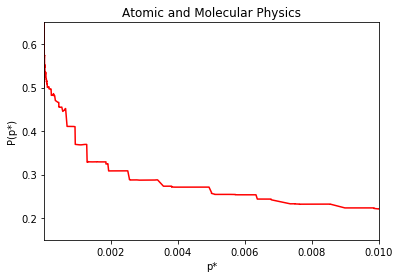

In [0]:
y_low = 0.15
y_high = 0.65
title = 'Atomic and Molecular Physics' 

plt.figure(1)
plt.plot(plist, np.array(klist)/np.array(mlist), color ='red')

plt.title(title)
plt.xlabel("p*")
plt.xlim(0.0000001,0.01)
plt.ylabel("P(p*)")
plt.ylim(ymin=y_low, ymax=y_high)

## Toy

In [0]:
otoy = pd.DataFrame([['10.1103/PhysRevA.49.1637'],
  ['10.1103/PhysRevA.33.3706'],
  ['10.1103/PhysRevA.71.032514'],
  ['10.1103/PhysRevA.73.022503'],
  ['10.1103/PhysRevA.70.032502'],
  ['10.1103/PhysRevA.77.032511'],
  ['10.1103/PhysRevLett.99.240402'],
  ['10.1103/PhysRevA.72.062502'],
  ['10.1103/PhysRevLett.95.050407'],
  ['10.1103/PhysRevLett.101.240406'],
  ['10.1103/PhysRevA.53.168'],
  ['10.1103/PhysRevA.77.044501'],
  ['10.1103/PhysRevE.53.4236'],
  ['10.1103/PhysRevD.64.036007'],
  ['10.1103/PhysRevA.56.139'],
  ['10.1103/PhysRevD.76.125028'],
  ['10.1103/PhysRevD.63.056002'],
  ['10.1103/PhysRevLett.64.2733'],
  ['10.1103/PhysRevD.50.5443'],
  ['10.1103/PhysRevD.45.1233'],
  ['10.1103/PhysRevA.54.3790'],
  ['10.1103/PhysRevD.46.1088'],
  ['10.1103/PhysRevA.51.4419'],
  ['10.1103/PhysRevA.60.5091'],
  ['10.1103/PhysRevD.46.5177'],
  ['10.1103/PhysRevA.44.4728'],
  ['10.1103/PhysRevE.71.026705'],
  ['10.1103/PhysRevD.50.4611'],
  ['10.1103/PhysRevE.75.026705'],
  ['10.1103/PhysRevE.64.016703'],
  ['10.1103/PhysRevD.79.114007'],
  ['10.1103/PhysRevE.59.1207'],
  ['10.1103/PhysRevD.79.094020']], columns=['doi'])

print(len(otoy))
otoy.head()

6


,doi
0,10.1103/PhysRevE.71.037401
1,10.1103/PhysRevE.66.035102
2,10.1103/PhysRevE.77.026219
3,10.1103/PhysRevE.78.016206
4,10.1103/PhysRevE.78.056212


In [0]:
otoy_test = otoy.merge(rhom, left_on='doi', right_on='paper', how='inner').drop(['doi'], axis=1)
print(len(otoy_test))

code = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "AA", "AB", "AC", "AD", "AE", "AF"]

otoy_test = otoy_test.sort_values('year')
otoy_test['code'] = code

otoy_test

6


,paper,gender,year,code
1,10.1103/PhysRevE.66.035102,male,2002,B
0,10.1103/PhysRevE.71.037401,male,2005,A
2,10.1103/PhysRevE.77.026219,male,2008,C
3,10.1103/PhysRevE.78.016206,male,2008,D
4,10.1103/PhysRevE.78.056212,male,2008,E
5,10.1103/PhysRevE.79.066211,male,2009,F


In [0]:
cb = cb[['citing_doi', 'cited_doi']]
toytest = pd.merge(otoy_test, cb, left_on='paper', right_on='citing_doi', how='left').drop(['citing_doi'], axis=1)
toytest.columns = ['paper', 'pgender', 'pyear', 'pcode', 'cited_doi']
toytest = toytest.merge(rhom, left_on='cited_doi', right_on='paper', how='inner').drop(['cited_doi'], axis=1)
toytest.columns = ['paper', 'pgender', 'pyear', 'pcode', 'reference', 'rgender', 'ryear']
toytest = toytest.merge(otoy_test, left_on='reference', right_on='paper', how='inner').drop(['paper_y', 'gender', 'year'], axis=1)
toytest.columns = ['paper', 'pgender', 'pyear', 'pcode', 'reference', 'rgender', 'ryear', 'rcode']

toytest = toytest[toytest['reference'].isin(otoy_test.paper)]

toytest['count'] = toytest.groupby('reference')['reference'].transform('count')
toytest.sort_values("count", axis = 0, ascending = True, inplace = True, na_position ='first')

print(len(toytest))
toytest

9


,paper,pgender,pyear,pcode,reference,rgender,ryear,rcode,count
8,10.1103/PhysRevE.79.066211,male,2009,F,10.1103/PhysRevE.78.056212,male,2008,E,1
6,10.1103/PhysRevE.78.056212,male,2008,E,10.1103/PhysRevE.78.016206,male,2008,D,2
7,10.1103/PhysRevE.79.066211,male,2009,F,10.1103/PhysRevE.78.016206,male,2008,D,2
0,10.1103/PhysRevE.77.026219,male,2008,C,10.1103/PhysRevE.66.035102,male,2002,B,3
1,10.1103/PhysRevE.78.056212,male,2008,E,10.1103/PhysRevE.66.035102,male,2002,B,3
2,10.1103/PhysRevE.79.066211,male,2009,F,10.1103/PhysRevE.66.035102,male,2002,B,3
3,10.1103/PhysRevE.78.016206,male,2008,D,10.1103/PhysRevE.77.026219,male,2008,C,3
4,10.1103/PhysRevE.78.056212,male,2008,E,10.1103/PhysRevE.77.026219,male,2008,C,3
5,10.1103/PhysRevE.79.066211,male,2009,F,10.1103/PhysRevE.77.026219,male,2008,C,3


In [0]:
cb = cb[['citing_doi', 'cited_doi']]
toy = pd.merge(otoy, cb, left_on='doi', right_on='citing_doi', how='left').drop(['citing_doi'], axis=1)
toy.columns = ['paper', 'reference']
toy = toy[toy['reference'].isin(otoy.doi)]

toy['count'] = toy.groupby('reference')['reference'].transform('count')
toy.sort_values("count", axis = 0, ascending = True, inplace = True, na_position ='first')

print(len(toy))
toy

9


,paper,reference,count
79,10.1103/PhysRevE.79.066211,10.1103/PhysRevE.78.056212,1
62,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.78.016206,2
78,10.1103/PhysRevE.79.066211,10.1103/PhysRevE.78.016206,2
20,10.1103/PhysRevE.77.026219,10.1103/PhysRevE.66.035102,3
39,10.1103/PhysRevE.78.016206,10.1103/PhysRevE.77.026219,3
56,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.66.035102,3
61,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.77.026219,3
72,10.1103/PhysRevE.79.066211,10.1103/PhysRevE.66.035102,3
77,10.1103/PhysRevE.79.066211,10.1103/PhysRevE.77.026219,3


In [0]:
# Step 02: Creating a dictionary of 'hom's by count

toy_s={key:toy[toy['count']==key] for key in toy['count'].unique()}

In [0]:
# Step 03: Link papers with connections together as groups

from collections import defaultdict
from itertools import combinations as comb
import random

toyy = {}
tunique_list = {}
for key, sub_toy_s in toy_s.items():
  cbt = sub_toy_s
  from_doi = cbt["paper"]
  to_doi = cbt["reference"]

  tunique_list[key] = len(to_doi.unique())

  parent = {}
  for ref in to_doi.unique():
    parent[ref] = []
  for a, b in zip(from_doi, to_doi):
    parent[b].append(a)

  pair_count = {}
  for l in parent.values():
    for tp in comb(sorted(l), 2):
      if tp in pair_count:
        pair_count[tp] += 1
      else:
        pair_count[tp] = 1
  dfc = []
  for p, value in pair_count.items():
    dfc.append([p[0], p[1], value])
  dfc = pd.DataFrame(dfc, columns=['paper1', 'paper2', 'common'])
  toyy[key] = dfc

In [0]:
# Step 04: Creating a dictionary: paper1, paper2, reference, common, freq1, freq2

from itertools import combinations as comb

freq = {}

for key, tables in toyy.items():
  ftable = toy_s[key].groupby(["paper"]).size().reset_index(name='frequency')
  freq[key] = ftable

fin = {}
for key, tables in toyy.items():
  if len(tables) > 0:
    tcount = freq[key]
    final_table = tables.merge(tcount, left_on='paper1', right_on='paper')
    final_table = final_table.merge(tcount, left_on='paper2', right_on='paper')
    final_table = final_table.drop(['paper_x', 'paper_y'], axis=1)
    
    fin[key] = final_table

In [0]:
# Step 05: Assigning q-values to all pairs

H_func = scipy.stats.hypergeom.pmf

for key, table in fin.items():
  qval = []
  _dp = {}
  nbk = tunique_list[key]

  for i, r in table.iterrows():
    Hs = []
    di, dj = r['frequency_x'], r['frequency_y']
    nijk = r['common']

    for X in range(nijk):
      _ref = (X, nbk, di, dj)
      if _ref in _dp:
        H = _dp[_ref]
      else:
        H = H_func(X, nbk, di, dj)
        _dp[_ref] = H
      Hs.append(H)

    qval.append(1-sum(Hs))

  fin[key]['qval'] = qval

In [0]:
# Step 06: Creating a DataFrame: paper1, paper2, common, freq1, freq2, qval

df = pd.concat(fin.values())
df.groupby(['paper1', 'paper2']).size()
df = df.sort_values(['paper1', 'paper2'])
print(len(df))
df.sort_values('common', ascending=False)

6


,paper1,paper2,common,frequency_x,frequency_y,qval
3,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.79.066211,2,2,2,1.0
0,10.1103/PhysRevE.77.026219,10.1103/PhysRevE.78.056212,1,1,2,1.0
2,10.1103/PhysRevE.77.026219,10.1103/PhysRevE.79.066211,1,1,2,1.0
1,10.1103/PhysRevE.78.016206,10.1103/PhysRevE.78.056212,1,1,2,1.0
4,10.1103/PhysRevE.78.016206,10.1103/PhysRevE.79.066211,1,1,2,1.0
0,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.79.066211,1,1,1,1.0


In [0]:
# Step 07: Combining equivalent pairs together with the minimum qval

dff = df.drop(["common", "frequency_x", "frequency_y"], axis=1).sort_values(["paper1", "paper2", "qval"]).reset_index(drop=True)
dff_min = dff.groupby(["paper1", "paper2"], as_index=False).min()
dff_min_qval = np.array(dff_min['qval'])

print(len(dff_min))
dff_min.sort_values('qval').head()

5


,paper1,paper2,qval
0,10.1103/PhysRevE.77.026219,10.1103/PhysRevE.78.056212,1.0
1,10.1103/PhysRevE.77.026219,10.1103/PhysRevE.79.066211,1.0
2,10.1103/PhysRevE.78.016206,10.1103/PhysRevE.78.056212,1.0
3,10.1103/PhysRevE.78.016206,10.1103/PhysRevE.79.066211,1.0
4,10.1103/PhysRevE.78.056212,10.1103/PhysRevE.79.066211,1.0


In [0]:
# Step 08: Assigning k to all pairs

cb['pair'] = "(" + cb["citing_doi"] + ", " + cb["cited_doi"] + ")"
cb['pair2'] = "(" + cb["cited_doi"] + ", " + cb["citing_doi"] + ")"

pairs = "(" + dff_min["paper1"] + ", " + dff_min["paper2"] + ")"
dff_min['k'] = pairs.isin(cb.pair) | pairs.isin(cb.pair2)

print(len(dff_min))
print(sum(dff_min['k']))
dff_min.head()

42
14


,paper1,paper2,qval,k
0,10.1103/PhysRevA.44.4728,10.1103/PhysRevA.51.4419,1.0,False
1,10.1103/PhysRevA.44.4728,10.1103/PhysRevA.54.3790,1.0,False
2,10.1103/PhysRevA.44.4728,10.1103/PhysRevA.56.139,1.0,False
3,10.1103/PhysRevA.44.4728,10.1103/PhysRevA.60.5091,1.0,False
4,10.1103/PhysRevA.44.4728,10.1103/PhysRevD.46.5177,1.0,False


In [0]:
# Step 09: Merging a DataFrame: adding gender & year

dff_min = dff_min.merge(rhom, left_on='paper1', right_on='paper', how='inner')
dff_min = dff_min.drop(['paper'], axis=1)
dff_min = dff_min.rename({'gender': 'gender1', 'year': 'year1'}, axis=1)

dff_min = dff_min.merge(rhom, left_on='paper2', right_on='paper', how='inner')
dff_min = dff_min.drop(['paper'], axis=1)
dff_min = dff_min.rename({'gender': 'gender2', 'year': 'year2'}, axis=1)

cols = ['paper1', 'gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k']

dff_min = dff_min.reindex(columns=cols)

print(len(dff_min))
dff_min.head()

42


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.44.4728,male,1991,10.1103/PhysRevA.51.4419,male,1995,1.0,False
1,10.1103/PhysRevA.44.4728,male,1991,10.1103/PhysRevA.54.3790,male,1996,1.0,False
2,10.1103/PhysRevA.51.4419,male,1995,10.1103/PhysRevA.54.3790,male,1996,1.0,False
3,10.1103/PhysRevA.44.4728,male,1991,10.1103/PhysRevA.56.139,male,1997,1.0,False
4,10.1103/PhysRevA.51.4419,male,1995,10.1103/PhysRevA.56.139,male,1997,1.0,True


In [0]:
df_test = dff_min.merge(otoy_test, left_on = 'paper1', right_on = 'paper', how='inner').drop(['paper', 'gender', 'year'], axis=1)
df_test.columns = ['paper1', 'gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k', 'code1']

df_test = df_test.merge(otoy_test, left_on = 'paper2', right_on = 'paper', how='inner').drop(['paper', 'gender', 'year'], axis=1)
df_test.columns = ['paper1', 'gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k', 'code1', 'code2']

print(len(df_test))
df_test.sort_values('qval')

42


,paper1,gender1,year1,paper2,gender2,year2,qval,k,code1,code2
19,10.1103/PhysRevD.64.036007,male,2001,10.1103/PhysRevD.76.125028,male,2007,0.166667,True,P,Z
41,10.1103/PhysRevE.53.4236,male,1996,10.1103/PhysRevLett.95.050407,male,2005,0.200000,False,M,W
39,10.1103/PhysRevA.77.044501,male,2008,10.1103/PhysRevE.53.4236,male,1996,0.200000,False,AB,M
38,10.1103/PhysRevLett.101.240406,male,2008,10.1103/PhysRevLett.99.240402,male,2007,0.200000,True,AC,AA
27,10.1103/PhysRevD.63.056002,male,2001,10.1103/PhysRevD.64.036007,male,2001,0.200000,True,Q,P
36,10.1103/PhysRevA.72.062502,male,2005,10.1103/PhysRevLett.99.240402,male,2007,0.200000,True,T,AA
5,10.1103/PhysRevA.54.3790,male,1996,10.1103/PhysRevA.56.139,male,1997,0.200000,True,L,N
35,10.1103/PhysRevA.72.062502,male,2005,10.1103/PhysRevLett.101.240406,male,2008,0.200000,True,T,AC
34,10.1103/PhysRevA.73.022503,male,2006,10.1103/PhysRevA.77.032511,male,2008,0.200000,True,X,AD
40,10.1103/PhysRevA.77.044501,male,2008,10.1103/PhysRevLett.95.050407,male,2005,0.200000,False,AB,W


In [0]:
homn = dff_min

homn_qval = np.array(homn['qval'])

plist = np.unique(homn_qval)
klist = []
mlist = []

for pstar in tqdm(plist):
    result = homn_qval < pstar
    sim = homn[result]
    mlist.append(len(sim))
    klist.append(sum(sim["k"]))

100%|██████████| 7/7 [00:00<00:00, 806.51it/s]


Text(0, 0.5, 'count')

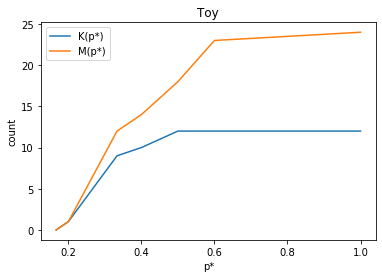

In [0]:
plt.plot(plist, klist)
plt.plot(plist, mlist)

plt.title('Toy')
plt.legend(['K(p*)', 'M(p*)'], loc='upper left')
plt.xlabel("p*")
# plt.xlim(0,0.01)
plt.ylabel("count")
# plt.ylim(0,1500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'P(p*)')

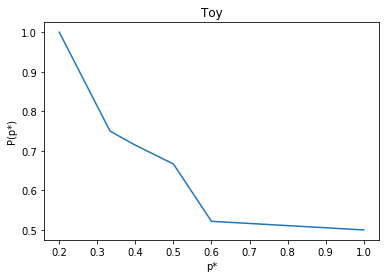

In [0]:
plt.plot(plist, np.array(klist)/np.array(mlist))

plt.title('Toy')
# plt.legend(['total', 'paired'], loc='upper right')
plt.xlabel("p*")
# plt.xlim(0.2,0.4)
plt.ylabel("P(p*)")
# plt.ylim(ymin=0, ymax=0.0002)

## Pairwise Count

In [0]:
dc = data[["doi", "year"]].drop_duplicates(subset = 'doi')
dc = dc.merge(cb, left_on = 'doi', right_on = 'citing_doi', how = 'inner')
dc = dc.drop(['doi'], axis=1)
dc = dc.rename({'year': 'citing_year'}, axis=1)

cols = ['citing_doi', 'citing_year', 'cited_doi']
dc = dc.reindex(columns=cols).sort_values('cited_doi')

print(len(dc))
dc.head()

2815130


,citing_doi,citing_year,cited_doi
18906,10.1103/PhysRev.8.221,1916,10.1103/PhysRev.1.16
18905,10.1103/PhysRevSeriesI.2.1,1894,10.1103/PhysRev.1.2
19356,10.1103/PhysRev.7.62,1916,10.1103/PhysRev.1.274
15720,10.1103/PhysRevB.13.2305,1976,10.1103/PhysRev.1.294
19358,10.1103/PhysRevB.31.4802,1985,10.1103/PhysRev.1.294


In [0]:
hom_mf = homn[homn["gender1"] != homn["gender2"]].reset_index(drop=True)

test = hom_mf.merge(dc, left_on = 'paper1', right_on = 'cited_doi', how = 'left')
test = test.drop(["cited_doi", "citing_year"], axis=1).drop_duplicates(subset=['paper1', 'citing_doi'])
test['count'] = test.groupby(['paper1'])['paper1'].transform('count')
test = test.drop(["citing_doi"], axis=1)
test = test.rename({'count': 'count1'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(['gender1', 'year1', 'paper2', 'gender2', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper1', how='inner')

test = hom_mf.merge(dc, left_on = 'paper2', right_on = 'cited_doi', how = 'left')
test = test.drop(["cited_doi", "citing_year"], axis=1).drop_duplicates(subset=['paper2', 'citing_doi'])
test['count'] = test.groupby(['paper2'])['paper2'].transform('count')
test = test.drop(["citing_doi"], axis=1)
test = test.rename({'count': 'count2'}, axis=1)

test = test.drop_duplicates(subset=['paper1', 'paper2']).drop(['gender1', 'year1', 'paper1', 'gender2', 'count1', 'year2', 'qval', 'k'], axis=1)
hom_mf = hom_mf.merge(test, on='paper2', how='inner')

del test

print(len(hom_mf))
print(hom_mf['paper1'].nunique())
hom_mf.head()

18760
2599


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3


In [0]:
listd = []

for c in range(len(hom_mf)):
  if hom_mf['gender1'][c] == 'male':
    listd.append(hom_mf['count1'][c] - hom_mf['count2'][c])
  else:
    listd.append(hom_mf['count2'][c] - hom_mf['count1'][c])

hom_mf['countd'] = listd

print(len(hom_mf))
hom_mf.head()

18760


,paper1,gender1,year1,paper2,gender2,year2,qval,k,count1,count2,countd
0,10.1103/PhysRevA.42.3587,male,1990,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,14,3,11
1,10.1103/PhysRevD.48.5655,male,1993,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,8,3,5
2,10.1103/PhysRevD.50.1161,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,1,3,-2
3,10.1103/PhysRevD.50.3847,male,1994,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1
4,10.1103/PhysRevD.52.6901,male,1995,10.1103/PhysRevD.56.3296,female,1997,0.009174,False,4,3,1


In [0]:
p = 0.006

homp = hom_mf[hom_mf['qval'] < p].sort_values('countd').reset_index(drop=True)

mlist = []
fmlist = []

for i in range(len(homp)):
  if homp['gender1'][i] == 'male':
    mlist.append(homp['count1'][i])
    fmlist.append(homp['count2'][i])
  else:
    mlist.append(homp['count2'][i])
    fmlist.append(homp['count1'][i])

sd = math.sqrt((np.std(mlist) ** 2 + np.std(fmlist) ** 2)/len(homp))

print((np.mean(mlist)-np.mean(fmlist))/sd)

4.26571880500725


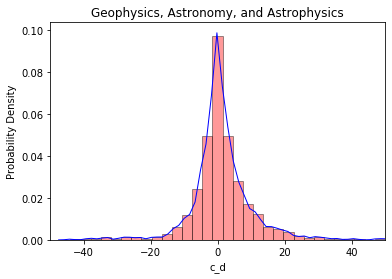

In [0]:
x = homp['countd']

# Density Plot and Histogram of all arrival delays

sns.distplot(x, hist=True, kde=True, bins=int((x.max()-x.min())/3),
             hist_kws={'edgecolor':'black', 'color': 'r'},
             kde_kws={'linewidth': 1, 'color': 'b'})

plt.title('Geophysics, Astronomy, and Astrophysics')
plt.xlim(-50, 50)
plt.ylim(ymin=0)
plt.xlabel("c_d")
plt.ylabel("Probability Density")

plt.show()

## Boxplots

In [0]:
# h0 = []
# h1 = []
# h2 = []
# h3 = []
# h4 = []
# h5 = []
# h6 = []
# h7 = []
# h8 = []
# h9 = []

In [0]:
# h0.append(x)
# h1.append(x)
# h2.append(x)
# h3.append(x)
# h4.append(x)
# h5.append(x)
# h6.append(x)
# h7.append(x)
# h8.append(x)
h9.append(x)

In [0]:
h0s = pd.DataFrame(h0).T
h1s = pd.DataFrame(h1).T
h2s = pd.DataFrame(h2).T
h3s = pd.DataFrame(h3).T
h4s = pd.DataFrame(h4).T
h5s = pd.DataFrame(h5).T
h6s = pd.DataFrame(h6).T
h7s = pd.DataFrame(h7).T
h8s = pd.DataFrame(h8).T
h9s = pd.DataFrame(h9).T

hs = pd.concat([h0s, h1s, h2s, h3s, h4s, h5s, h6s, h7s, h8s, h9s], ignore_index=True, axis=1)
hs.columns = ['00', '10', '20', '30', '40', '50', '60', '70', '80', '90']

hs.head()

,00,10,20,30,40,50,60,70,80,90
0,-568.0,-126.0,-31.0,-89.0,-87.0,-19.0,-65.0,-234,-568.0,-44.0
1,-568.0,-126.0,-23.0,-87.0,-75.0,-9.0,-65.0,-233,-166.0,-39.0
2,-568.0,-124.0,-23.0,-75.0,-74.0,-6.0,-61.0,-232,-75.0,-38.0
3,-568.0,-121.0,-22.0,-58.0,-70.0,-5.0,-60.0,-231,-71.0,-37.0
4,-568.0,-115.0,-22.0,-58.0,-69.0,-4.0,-50.0,-228,-70.0,-34.0


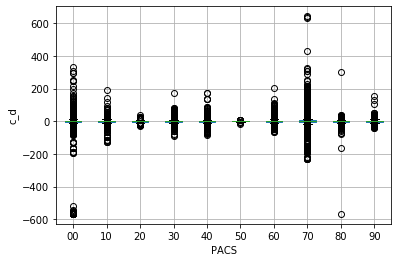

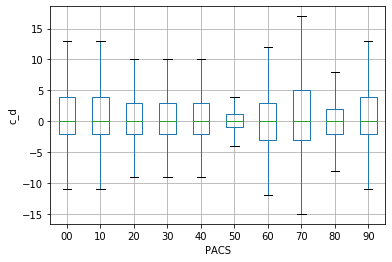

In [0]:
plt.figure(1)
hs.boxplot() # w/o outliers

# plt.title("Statistics of c_M - c_F")
plt.xlabel("PACS")
plt.ylabel("c_d")

plt.figure(2)
hs.boxplot(showfliers=False) # w/o outliers

# plt.title("Statistics of c_M - c_F")
plt.xlabel("PACS")
plt.ylabel("c_d")

plt.show()

## PageRank for Homophily

### Analysis

In [0]:
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi', target='cited_doi', create_using=Graphtype)

pr = nx.pagerank(C)

prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['centrality'] = pr.values()
prs.sort_values('centrality', ascending=False).head()

nodedata = data[data['is_alpha'] == False]
nodedata = nodedata[nodedata['order'] == 1]
nodedata = nodedata.drop(['order', 'numAuthor',	'is_last',	'is_alpha',	'year',	'articleType',	'journal', 'id'], axis=1)
nodedata = nodedata.reset_index()
nodedata.columns = ['id', 'Label', 'Gender']

prs = prs.merge(nodedata, left_on='doi', right_on='Label', how='left')
prs = prs.drop(['Label'], axis=1)
prs = prs[["doi", 'id', 'Gender', 'centrality']]
prs = prs.sort_values('centrality', ascending=False)

prs.head()

,doi,id,Gender,centrality
0,10.1103/PhysRevB.1.3614,2327,female,0.000002
1,10.1103/PhysRev.91.174,102128,male,0.000078
2,10.1103/PhysRev.92.1367,102129,male,0.000018
3,10.1103/RevModPhys.62.251,29386,male,0.000305
4,10.1103/PhysRevA.10.1494,41171,male,0.000040


In [0]:
ph = pd.merge(homn, prs, left_on = "paper1", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen1"})

ph = ph.merge(prs, left_on = "paper2", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen2"})
print(len(ph))

ph = ph[ph['gender1'] != ph['gender2']].reset_index(drop=True)

listd = []

for c in range(len(ph)):
  if ph['gender1'][c] == 'male':
    listd.append(ph['cen1'][c] - ph['cen2'][c])
  else:
    listd.append(ph['cen2'][c] - ph['cen1'][c])

ph['cen_d'] = listd

print(len(ph))
ph.head()

1189255
184694


,paper1,gender1,year1,paper2,gender2,year2,qval,k,cen1,cen2,cen_d
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,0.000018,0.000004,1.402271e-05
1,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False,0.000004,0.000005,7.764608e-07
2,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.824713e-06
3,10.1103/PhysRevA.39.5466,female,1989,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.166712e-06
4,10.1103/PhysRevA.41.3081,female,1990,10.1103/PhysRevA.41.784,male,1990,0.000511,False,0.000002,0.000005,2.824713e-06


In [0]:
p = 0.002

phsub = ph[ph['qval'] < p].sort_values('cen_d').reset_index(drop=True)

mlist = []
fmlist = []

for i in range(len(phsub)):
  if phsub['gender1'][i] == 'male':
    mlist.append(phsub['cen1'][i])
    fmlist.append(phsub['cen2'][i])
  else:
    mlist.append(phsub['cen2'][i])
    fmlist.append(phsub['cen1'][i])

sd = math.sqrt((np.std(mlist) ** 2 + np.std(fmlist) ** 2)/len(phsub))

print((np.mean(mlist)-np.mean(fmlist))/sd)

-0.6457704432323805


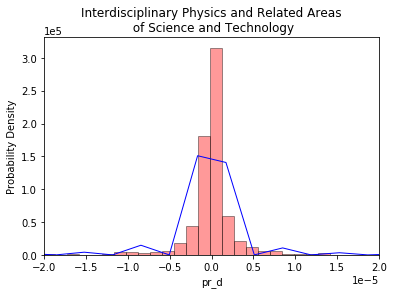

In [0]:
x = phsub['cen_d']

sns.distplot(x, hist=True, kde=True, bins=300,
             hist_kws={'edgecolor':'black', 'color': 'r'},
             kde_kws={'linewidth': 1, 'color': 'b'})


plt.title('Interdisciplinary Physics and Related Areas\n of Science and Technology')
plt.xlim(-0.00002, 0.00002)
plt.ylim(ymin=0)
plt.xlabel("pr_d")
plt.ylabel("Probability Density")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

## Boxplot2

In [0]:
# c0 = []  
# c1 = [] 
# c2 = []  
# c3 = []  
# c4 = []  
# c5 = []  
# c6 = [] 
# c7 = []
# c8 = []
# c9 = [] 

In [0]:
x = phsub['cen_d']

# c0.append(x)
# c1.append(x)
# c2.append(x)
# c3.append(x)
# c4.append(x)
# c5.append(x)
# c6.append(x)
# c7.append(x)
# c8.append(x)
c9.append(x)

In [0]:
c0s = pd.DataFrame(c0).T
c1s = pd.DataFrame(c1).T
c2s = pd.DataFrame(c2).T
c3s = pd.DataFrame(c3).T
c4s = pd.DataFrame(c4).T
c5s = pd.DataFrame(c5).T
c6s = pd.DataFrame(c6).T
c7s = pd.DataFrame(c7).T
c8s = pd.DataFrame(c8).T
c9s = pd.DataFrame(c9).T

cs = pd.concat([c0s, c1s, c2s, c3s, c4s, c5s, c6s, c7s, c8s, c9s], ignore_index=True, axis=1)
cs.columns = ['00', '10', '20', '30', '40', '50', '60', '70', '80', '90']

cs.head()

,00,10,20,30,40,50,60,70,80,90
0,-0.000289,-0.000107,-0.000027,-0.000080,-0.000080,-0.000006,-0.000044,-0.000136,-0.000289,-0.000069
1,-0.000289,-0.000107,-0.000021,-0.000078,-0.000056,-0.000006,-0.000043,-0.000125,-0.000057,-0.000059
2,-0.000289,-0.000107,-0.000017,-0.000056,-0.000054,-0.000002,-0.000041,-0.000125,-0.000023,-0.000025
3,-0.000289,-0.000106,-0.000013,-0.000056,-0.000054,-0.000002,-0.000034,-0.000125,-0.000020,-0.000021
4,-0.000289,-0.000106,-0.000012,-0.000054,-0.000048,-0.000002,-0.000033,-0.000125,-0.000019,-0.000021


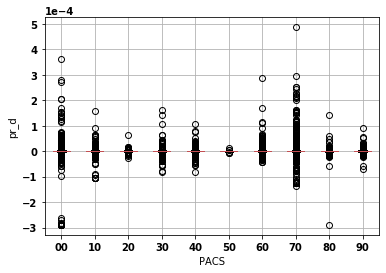

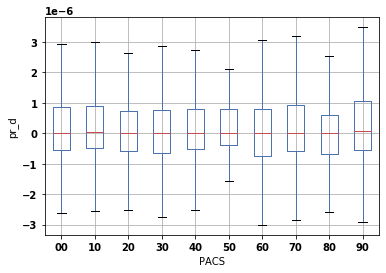

In [0]:
plt.figure(1)
cs.boxplot() # w/o outliers

# plt.title("Statistics of c_M - c_F")
plt.xlabel("PACS")
plt.ylabel("pr_d")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.figure(2)
cs.boxplot(showfliers=False) # w/o outliers

# plt.title("Statistics of c_M - c_F")
plt.xlabel("PACS")
plt.ylabel("pr_d")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()